<a href="https://colab.research.google.com/github/AnnaDS/Stock_forecast/blob/main/forecasting/Supervised_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM and XGboost models

### Connect to Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir('drive/MyDrive/stock_forecast/forecasting/lib')



['models.py', 'get_data.py', 'data_prep.py', '__pycache__']

### Import data and required functions

In [ ]:
from drive.MyDrive.stock_forecast.forecasting.lib.data_prep import prepare_data_feat_step
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

stock_price=pd.read_csv('drive/MyDrive/stock_forecast/data/TSLA.csv')
stock_price.index=pd.DatetimeIndex(stock_price['Unnamed: 0'])

### Prepare Training and testing data

In [ ]:
training_days=int(len(stock_price)*0.75)
n_lags=5
step=0
target_col='Close'
extra_features=['Volume']
X_train, y_train, X_test, real_stock_price, sc_extra=prepare_data_feat_step(stock_price, training_days, n_lags, step, target_col, extra_features)


### Create and train LSTM model

In [ ]:
from drive.MyDrive.stock_forecast.forecasting.lib.models import rnn_model, lstm_horizon_model
y_train = y_train.reshape(-1, 1)
lstm_model = lstm_horizon_model(X_train, y_train)


In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
# Define TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with TensorBoard callback
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[tensorboard_callback])

Epoch 1/50
13/13 [==============================] - 11s 183ms/step - loss: 0.1816 - val_loss: 0.0064
Epoch 2/50
13/13 [==============================] - 0s 29ms/step - loss: 0.0430 - val_loss: 0.0067
Epoch 3/50
13/13 [==============================] - 0s 27ms/step - loss: 0.0332 - val_loss: 0.0101
Epoch 4/50
13/13 [==============================] - 0s 30ms/step - loss: 0.0232 - val_loss: 0.0031
Epoch 5/50
13/13 [==============================] - 0s 29ms/step - loss: 0.0165 - val_loss: 0.0027
Epoch 6/50
13/13 [==============================] - 0s 28ms/step - loss: 0.0100 - val_loss: 0.0016
Epoch 7/50
13/13 [==============================] - 0s 31ms/step - loss: 0.0084 - val_loss: 0.0020
Epoch 8/50
13/13 [==============================] - 0s 29ms/step - loss: 0.0103 - val_loss: 0.0018
Epoch 9/50
13/13 [==============================] - 0s 29ms/step - loss: 0.0089 - val_loss: 0.0015
Epoch 10/50
13/13 [==============================] - 0s 31ms/step - loss: 0.0082 - val_loss: 0.0018
Epoch 1

Test predicting single value

In [ ]:
# To predict a single value
def predict_single_value(model, X_input):
    X_input = np.expand_dims(X_input, axis=0)  # Adjust shape to (1, 5, 2)
    prediction = model.predict(X_input)
    return prediction

# Example usage:
X_sample = X_train[0]  # Example input, a single sample from X_train
predicted_value = predict_single_value(lstm_model, X_sample)
sc=sc_extra[target_col]
print(sc.inverse_transform(predicted_value))

1/1 [==============================] - 2s 2s/step
[[237.3654]]


### Predict test using LSTM model

6/6 [==============================] - 0s 5ms/step


<Axes: >

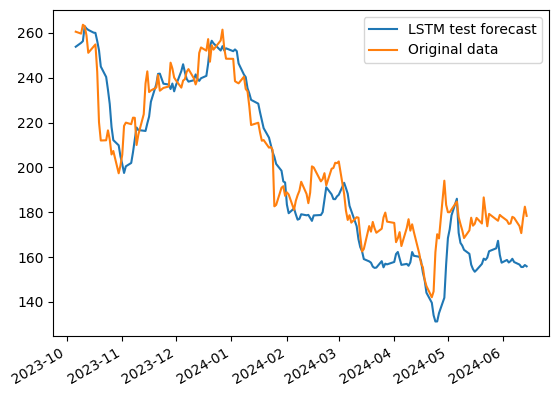

In [ ]:
#predict test with trained model
#
y_pred=lstm_model.predict(X_test)
#get the right scaller
sc=sc_extra[target_col]
y_pred=sc.inverse_transform(y_pred)

y_pred_df=pd.DataFrame({'LSTM test forecast':y_pred.reshape(-1),
                        'Original data':real_stock_price[target_col].values},
                        index=real_stock_price.index.values)

y_pred_df.plot()


### Create autoregressive model for the all predicted horizon of test data

In [ ]:
def autoregressive_forecast(model, X_test, n_forecast_steps):
    """
    Make autoregressive forecasts using the trained LSTM model.

    Args:
        model (Sequential): Trained LSTM model.
        X_test (np.ndarray): Initial test data.
        n_forecast_steps (int): Number of steps to forecast into the future.

    Returns:
        np.ndarray: Forecasted values.
    """
    predictions = []
    input_sequence = X_test[-1, :, :].copy()

    for _ in range(n_forecast_steps):
        #print(input_sequence[np.newaxis, :, :])
        prediction = model.predict(input_sequence[np.newaxis, :, :])[0, 0]
        predictions.append(prediction)
        # Append the new prediction and remove the oldest value to maintain the sequence length
        input_sequence = np.append(input_sequence[1:], [[prediction] + list(input_sequence[-1, 1:])], axis=0)

    return np.array(predictions)


# Make autoregressive forecast
#n_forecast_steps = 30  # Number of steps to forecast
#predictions = autoregressive_forecast(lstm_model, X_test, n_forecast_steps)

n_forecast_steps = len(X_test)  # Number of steps to forecast
lstm_test_predictions = autoregressive_forecast(lstm_model, X_train, n_forecast_steps)


1/1 [==============================] - 0s 41ms/step


In [ ]:
# Inverse transform the predictions to get the actual values
lstm_test_predictions = sc_extra[target_col].inverse_transform(lstm_test_predictions.reshape(-1, 1)).flatten()

In [ ]:
#Getting date range for a testing period
train_ind=stock_price.iloc[n_lags:training_days].index
start_date = train_ind[-1]

# Generate a range of 30 business days starting from the last date in the stock_price index
business_days = pd.bdate_range(start=start_date, periods=n_forecast_steps)

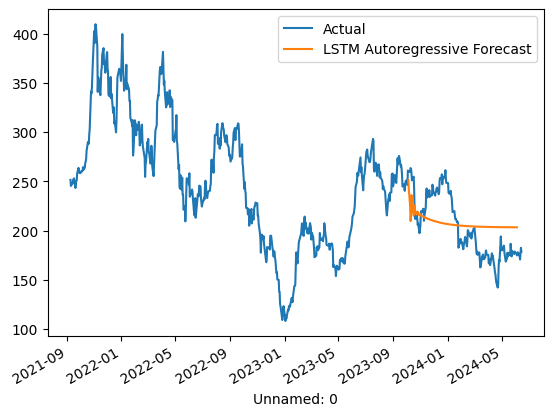

In [ ]:

stock_price['Close'].plot(label='Actual')
pd.Series(lstm_test_predictions, index=business_days).plot(label='LSTM Autoregressive Forecast').plot()
plt.legend()
plt.show()

### Use XGBoost model

In [ ]:
#Get and train on scaled data
X_train_df=pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
col_vals=[target_col]+extra_features
cols_res=[]
for c in col_vals:
    for i in range(1, n_lags+1,1):
        cols_res.append(f'{c}_{n_lags-i+1}')
X_train_df.columns=cols_res
#train_ind=stock_price.iloc[n_lags:training_days].index

X_train_df.index=train_ind
y_train_df=pd.Series(y_train.squeeze(-1),index=train_ind)

X_test_df=pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_test_df.columns=cols_res

In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train_df,y_train_df )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_pred=xgb_model.predict(X_test_df)
sc=sc_extra[target_col]
xgb_pred=sc.inverse_transform(xgb_pred.reshape(len(xgb_pred),1))


<Axes: >

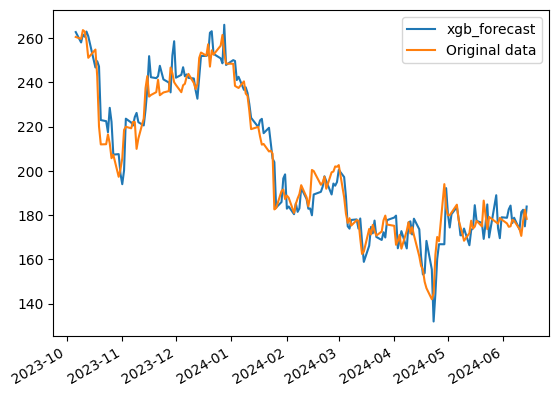

In [ ]:
xgb_pred_df=pd.DataFrame({'xgb_forecast':xgb_pred.reshape(-1),
                        'Original data':real_stock_price[target_col].values},
                        index=real_stock_price.index.values)

xgb_pred_df.plot()

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor


# Function to create autoregressive forecast
def autoregressive_forecast_xgboost(model, X_test_df, n_forecast_steps):
    """
    Make autoregressive forecasts using the trained XGBoost model.

    Args:
        model (XGBRegressor): Trained XGBoost model.
        X_test_df (pd.DataFrame): Initial test data.
        n_forecast_steps (int): Number of steps to forecast into the future.

    Returns:
        np.ndarray: Forecasted values.
    """
    predictions = []
    input_sequence = X_test_df.iloc[-1, :].copy()

    for _ in range(n_forecast_steps):
        #print(input_sequence)
        prediction = model.predict(input_sequence.values.reshape(1, -1))[0]
        predictions.append(prediction)
        #print(prediction)
        # Shift the input sequence and add the new prediction
        new_row = input_sequence.values.tolist()[len(extra_features):] + [prediction]
        input_sequence = pd.Series(new_row, index=input_sequence.index)

    return np.array(predictions)

# Make autoregressive forecast
n_forecast_steps = len(X_test)  # Number of steps to forecast
predictions = autoregressive_forecast_xgboost(xgb_model, X_train_df, n_forecast_steps)

# Inverse transform the predictions to get the actual values
predictions = sc_extra[target_col].inverse_transform(predictions.reshape(-1, 1)).flatten()

# Print the predictions
#print("XGBoost Autoregressive Forecasts:")
#print(predictions)


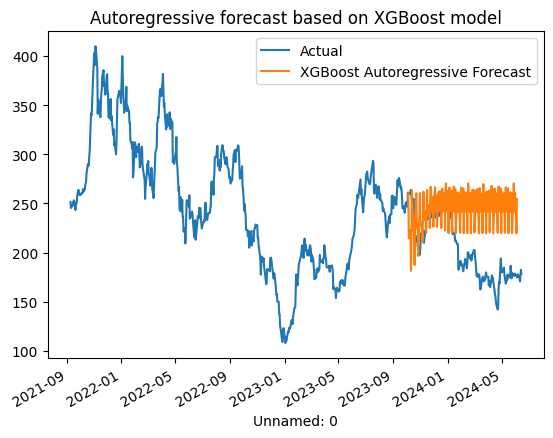

In [ ]:

stock_price['Close'].plot(label='Actual')
pd.Series(predictions, index=business_days).plot(label='XGBoost Autoregressive Forecast').plot()
plt.title('Autoregressive forecast based on XGBoost model')
plt.legend()
plt.show()

## Create autoregressive forecast for the next 30 days using LSTM and XGboost models. Compare results

In [ ]:
n_forecast_steps = 60  # Number of steps to forecast

# LSTM autoregressive forecast
lstm_predictions = autoregressive_forecast(lstm_model, X_test, n_forecast_steps)
# Inverse transform the predictions to get the actual values
lstm_predictions = sc_extra[target_col].inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()

# XGBoost autoregressive forecast
xgb_predictions = autoregressive_forecast_xgboost(xgb_model, X_test_df, n_forecast_steps)
# Inverse transform the predictions to get the actual values
xgb_predictions = sc_extra[target_col].inverse_transform(xgb_predictions.reshape(-1, 1)).flatten()


1/1 [==============================] - 0s 24ms/step


In [ ]:
# Getting date range for prediction
start_date=stock_price.index[-1]

# Generate a range of 30 business days starting from the last date in the stock_price index
business_days = pd.bdate_range(start=start_date, periods=n_forecast_steps)

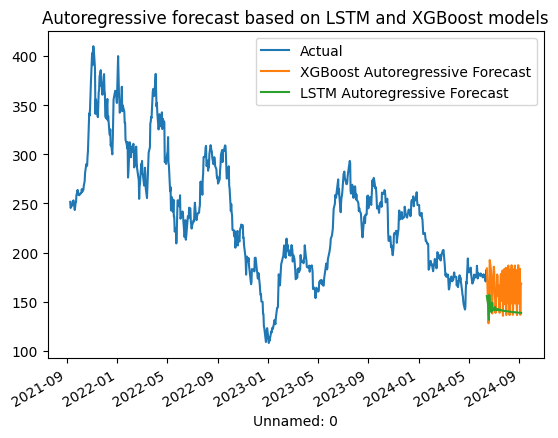

In [ ]:
stock_price['Close'].plot(label='Actual')

pd.Series(xgb_predictions, index=business_days).plot(label='XGBoost Autoregressive Forecast').plot()
pd.Series(lstm_predictions, index=business_days).plot(label='LSTM Autoregressive Forecast').plot()
plt.title('Autoregressive forecast based on LSTM and XGBoost models')
plt.legend()
plt.show()

In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!git config --global user.name "AnnaDS"

In [ ]:
!git config --global user.email "anna.chistyakova.prn@gmail.com"

In [ ]:
!git clone https://github.com/AnnaDS/Stock_forecast.git /content/drive/MyDrive/stock_forecast/Stock_forecast

Cloning into '/content/drive/MyDrive/stock_forecast/Stock_forecast'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 104 (delta 34), reused 72 (delta 14), pack-reused 0
Receiving objects: 100% (104/104), 1.22 MiB | 8.14 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
os.listdir('Stock_forecast')

['.DS_Store',
 '.git',
 'data',
 'forecasting',
 'docs',
 'README.md',
 'data_collect',
 'Supervised_models.ipynb',
 'requirements.txt',
 'Stock prediction project plan 5ce45c7a9aa24b2d8c8d5f002b80c5bf.md',
 'data_prep',
 'stock_forecat_environment.yml']

In [ ]:
os.c()

'/content'